# Neuro-Fuzzy Network
The following notebook explains the theory behind Fuzzy Neural Networks. After that you can find a use case example where the model is applied. We create rules and implement them into the network which we build with the prosper_nn package.

## Theory

An MLP neural network gets numerical input data, e.g., sensor data and predicts a numerical forcast. The input data is processed inside the network's hidden layers. What the network does within this process can hardly be interpreted. The neural fuzzy architecture whitens this black box by giving each hidden neuron and its connections a human interpretable verbal meaning. Because of this verbal meaning, we can construct rules for the network to follow. A simple example would be: "If input 1 increases, the output will fall". If experts have a basic understanding of the relations between input and output of our problem, we can use those rules for initialization of our network. We infuse the domain knowledge into the network. The basic principles of the architectures for regression (left) and classification (right) are shown below:<br>


<img src="images/Numerical_Verbal_Space.png" width="450" align="left">
<img src="images/Numerical_Verbal_Klassification.png" width="450" align="right">
<br>



The three steps **Fuzzification, Fuzzy-Inference** and **Defuzzification** are described in detail in the following chapters. 
Regression (left) needs one more step to translate back from verbal to numerical space. Classification (right) happens in the verbal space and therefore no defuzzification is necessary. For *Fuzzification* membership functions are used. In *Fuzzy-Inference* the domain knowledge is infused by formulating rules. *Defuzzification* translates back to the numerical space.


### Fuzzification

Fuzzification is the translation of numerical input values into a verbal description. This is achieved by membership functions. They divide the number domain of the input into groups. The functions define the membership of an input to these different groups. Within the package two membership function classes are defined:<br>
* **gaussian membership function**
    * zero-centered
    * width of the cone is learned during training
* **normlog membership function**
    * steepest tangent goes through zero
    * slope is learned during training
    * slope can not change its sign

The user can create his or her own membership functions if necessary.<br>
By using membership functions, the numerical value of an input is translated to the verbal space. E.g., an input can *decrease*, *increase* (corresponding normlog function) or stay *constant* (gaussian). By changing the parameters of the functions e.g. the width of the gaussian, the model learns what range of inputs corresponds with the membership term e.g. *constant* (for some measurements a fluctuation of 10 around 0 is considered stable, for others only a fluctuation of 0.1). <br>
<img src="images/Member.png" width="400" align="left"> 


### Fuzzy Inference

<img src="images/RuleWeights.png" width="500" align="right">

After translating the numerical input into a verbal description, we can apply the domain knowledge to the incoming data.
The domain knowledge about a given problem is infused into the network by IF/THEN rules. These rules can be modeled with the edge weights of layers. The relation "*IF input_1 increases THEN rule_1 applies*" can be modeled by setting the connection weight between node *input_1 increases* (output node of the corresponding membership function in `Fuzzification`) and node *rule_1* (`condition_fullfillment` in `Fuzzy-Inference`) to 1. **All weights that do not represent a rule are set to zero.** Example for a `conditions` matrix is shown on the right (2D input is flattened for visualization).<br>

An *AND* relation like "*IF input_1 increases AND input_2 decreases THEN rule_1 applies*" works after the same schema. More than one row is set to 1 in each column (see picture). For an *OR* relation create a new rule. Instead of: "*IF input_1 increases OR input_2 decreases THEN rule_1 applies*" we say: "*IF input_1 increases THEN rule_1 applies*" and "*IF input_2 decreases THEN rule_2 applies*". 

Knowing how much a condition of a rule is fulfilled, we have to classify based on the rules' consequences. 
In the `FuzzyInference` the meaning of a rule is infused by setting the connection of the `consequences` matrix. The classification rule "*IF rule_1 applies THEN class_1 should be predicted*" sets the corresponding node connection to 1. All other connections are set to 0. The generation of the `consequences` matrix is described in the use case example below. You can create as many rules as you want.

<img src="images/ClassificationWeights.png" width="450" align="left">
<img src="images/ClassificationWeights_after.png" width="450" align="right">

The layer has a constraint so that each column sums high to one. The entries of the matrix can be seen as a belief parameter of how much the network trusts the rule to predict the given class. When visualizing this matrix we can see which rules are strong and which ones are weak. On the left you can see the matrix before and on the right after training.<br>

In regression we classify the three classes *raising*, *stable* and *falling* in this layer. These three classes are the interpretable forecast of the Neuro Fuzzy Network. Depending on the values we see how likely the future bahaviour is.

### Defuzzification

In case of regression we have to calculate the numerical value corresponding to the verbal classification. This is done in the *Defuzzification* step of the network. We can use the `Defuzzification` layer that applies a Linear layer.  

# Fuzzy Neural Network Architecture

Overall, the architecture for regression looks like this (for classification the last, blue layer is cut). The Inference matrix $P$ contains the rule premises. The matrix $\kappa$ represents a belief value for each rule output, i.e. how much does the network trust the specific rules. The last matrix $W$ is responsible for Defuzzification.

<img src="images/Architecture.png" width="700" align="left">

## Neuro Fuzzy Example
First we import all packages that we will need:

In [1]:
import sys, os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

In [3]:
# Initialization
# RuleParser
from prosper_nn.models.fuzzy.rule_manager import RuleManager

# Layers
from prosper_nn.models.fuzzy.membership_functions import (
    NormlogMembership,
    GaussianMembership,
)
from prosper_nn.models.fuzzy.fuzzification import Fuzzification
from prosper_nn.models.fuzzy.fuzzy_inference import FuzzyInference
from prosper_nn.models.fuzzy.defuzzification import Defuzzification

# Utility
from prosper_nn.utils.visualization import plot_heatmap

### Data Preparation
We now use Prosper_nn to predict wine quality. For explanation of the data processing see the [Regression Notebook](Regression.ipynb). 

Second, we load the dataset, split it into a training and test set and create a training and test loader. We use a batchsize of 200.

In [4]:
batchsize = 16

In [5]:
df = pd.read_csv("data/winequality-red.csv", sep=";").sample(frac=1)

X = torch.tensor(df.drop(columns=["quality"]).values).float()
y = torch.tensor(df["quality"].values).float()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Normalize data
normalize_data = lambda x: (x - x.mean(dim=0)) / x.std(dim=0)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
y_train = normalize_data(y_train).reshape(-1, 1)
y_test = normalize_data(y_test).reshape(-1, 1)

# Bring the data in batch format
X_train = X_train[: -(X_train.shape[0] % batchsize)]
y_train = y_train[: -(y_train.shape[0] % batchsize)]
X_train = X_train.reshape(int(X_train.shape[0] / batchsize), batchsize, -1)
y_train = y_train.reshape(int(y_train.shape[0] / batchsize), batchsize, -1)

### Initialization
#### Rule Creation

If you want to infuse domain knowledge in form of rules into the network, you have to create the corresponding weight matrices for the `FuzzyInference` layer. In the following, we propose a method for the matrix creation, but you can create those matrices however you want if your framework does not suite you.<br>

#### JSON file
Rules are in a language domain. "*IF abc THEN xyz*". We want to store the rules in this domain to keep the ease of understanding them. We use a JSON file to store the rules and use a parser which creates the matrices from the JSON file.
The file has four entries:
* `"rules"`, here the conditions of the `FuzzyInference` are defined in an understandable form. 
* `"classification_rules"`, here it is defined which rule results in which class (consequence). 
* `"member_activations"`, here the numerical translation of the member activations are stored. 
* `"input_names"`, stores at what position in the network the corresponding parameter is put in. 
<br>

For our dataset we created the `demonstrator_rules.json` file whose content is shown below. Under `"rules"` 4 dummy entries are listed. We create a rule we think will influence high quality, one for low quality, one where two conditions have to be fullfilled and a complex rule with five conditions. 
Within the individual rules we define how each input must behave in order for the rule to apply.
In the `"classification_rule"` entry we define what rules result in which of our 3 error classes (low, average, high).
In `"input_names"` the names of the inputs are saved.
The dictionary "member_activations" stores what the verbal parameters of the rules mean numerically.

All JSON code snippets together form the `demonstrator_rules.json` file.

Under `"rules"` you define the inference. The naming of the individual rules is up to you. The inputs' names must match the ones defined in `"input_names"`.
The following rule `and_rule` should be read like this: "*and_rule applies IF citric_acid is average AND chlorids is low*". The other inputs have no influence on `and_rule`.

In [6]:
{
    "rules": {
        "high_quality": {"free_sulfur_dioxide": "high"},
        "low_quality": {"fixed_acidity": "low"},
        "and_rule": {"citric_acid": "average", "chlorides": "low"},
        "complex_rule": {
            "fixed_acidity": "high",
            "chlorides": "low",
            "density": "average",
            "citric_acid": "average",
            "residual_sugar": "low",
        },
    },
}


 What each rule means is defined in "classification_rules". In this demo: "*IF 2_E1_r1 THEN output at index \[1\]*"

In [7]:
{
    "classification_rules": {
        "high_quality": [2],
        "low_quality": [2],
        "and_rule": [1],
        "complex_rule": [1],
    },
}


It is important to know in which order the inputs are fed to the network. The order is defined in `"input_names"`. Each name is assigned at the index at which it is put into the network. The names can also be passed to the `Fuzzification` for a better overview during debugging (see [documentation](../api/fuzzy.rst#prosper_nn.models.fuzzy.fuzzification.Fuzzification) `Fuzzification`). 

In [8]:
{
    "input_names": {
        "fixed_acidity": 0,
        "volatile_acidity": 1,
        "citric_acid": 2,
        "residual_sugar": 3,
        "chlorides": 4,
        "free_sulfur_dioxide": 5,
        "total_sulfur_dioxide": 6,
        "density": 7,
        "pH": 8,
        "sulphates": 9,
        "alcohol": 10
  },
};

The meaning of the rule terms e.g. `"high", "low", "average"`, are stored in `"member_activations"`. Depending on the used membership functions you have to adjust this dictionary. The order of the membership functions in the `member_functions` dictionary of `Fuzzification` is important. Depending on the meaning of the membership functions, you can create the numerical description of corresponding relation.

In [9]:
{
    "member_activations": {
        "high": [0, 0, 1],
        "low": [1, 0, 0],
        "average": [0, 1, 0],
        "high_low": [1, 0, 1],
        "high_average": [0, 1, 1],
        "low_average": [1, 1, 0],
        "none": [0, 0, 0],
    }
}


This is the JSON file for the following membership functions:

In [10]:
membership_fcts = {
    "decrease": NormlogMembership(negative=True),
    "constant": GaussianMembership(),
    "increase": NormlogMembership(),
}

#### Parser
The class `RuleManager` can be used to parse the JSON file and create the `rule_matrix` and the `classification_matrix`. The matrices are created when initializing a new `RuleManager` object and can be used by an attribute call. The class takes the path to the JSON file as an initialization parameter as well as the matrices' shapes. We will use the `RuleManager` in the Initialization part to parse the JSON file.

The data has eleven inputs and 3 different classes. We defined 4 rules in the `demonstrator_rules.json` file. We use three membership functions (*increase*, *stable*, *decrease*). The shape of the `rule_matrix` is defined by those parameters. They have to be passed to the `RuleManager` in order to parse the JSON rules correctly.

In [11]:
n_features_input = 11
n_output_classes = 3
n_rules = 4
n_membership_fcts = 3

n_epochs = 20

rule_manager = RuleManager(
    path="data/demonstrator_rules.json",
    rule_matrix_shape=(n_rules, n_features_input, n_membership_fcts),
    classification_matrix_shape=(n_rules, n_output_classes),
)

#### Membership Function Usage
For fuzzification use the `Fuzzification` class. It applies a set of membership functions to each input. The layer has a 2D output tensor of `shape=(n_features_inputs, n_memberships_fcts)`. For each input the membership to each function of the set is calculated. This set is a python dictionary containing a custom name for each membership function as keys and the membership functions themselves. The `Fuzzification` below has three membership functions. It will have `n_input = 11` input features and `11*3 = 33` output features of `shape=(11, 3)`.

In [12]:
membership_fcts = {
    "decrease": NormlogMembership(negative=True),
    "constant": GaussianMembership(),
    "increase": NormlogMembership(),
}

fuzzification = Fuzzification(
    n_features_input=n_features_input, membership_fcts=membership_fcts
)

#### FuzzyInference Usage
For *Fuzzy-Inference* use the `FuzzyInference` class. It takes a 2D tensor as an input and outputs a 1D tensor. This fits since it follows the `Fuzzification`, which outputs a 2D tensor by default. As input parameters the `FuzzyInference` needs the number of inputs of the data set `n_features_input = 11`, the number of rules ` n_rules = 4`, the number of membership functions (`n_membership_fcts`) used in the previous `Fuzzification` and the number of output classes `n_output_classes`. The layer requires an optional `rule_matrix` parameter if rules should be used. Here, we use the `rule_matrix` of the previously created `rule_manager`. We set the parameter `learn_conditions` of the `FuzzyInference` to `True` and `prune_weights` to `False`, so all weights can change. If `prune_weights` is set to `True`, only the rule weights can change; all other stay zero. If `learn_conditions` is set to `False`, no weights change.
Similarly, we set the `classification_matrix` from the `rule_manager`.

In [13]:
fuzzy_inference = FuzzyInference(
    n_features_input=n_features_input,
    n_rules=n_rules,
    n_output_classes=n_output_classes,
    n_membership_fcts=n_membership_fcts,
    rule_matrix=rule_manager.rule_matrix,
    prune_weights=False,
    learn_conditions=True,
    classification_matrix=rule_manager.classification_matrix,
)

#### Defuzzification Usage
For the *Defuzzification* in a regression task we use the `Defuzzification` class. As parameters this layer takes the number of classes ` n_output_classes` and the number of outputs `n_features_output`. 
If we are in a classification task this layer is not needed. The consequence classes will directly be used as classification output.

In [14]:
defuzzification = Defuzzification(n_output_classes)

Now we can create our Fuzzy Neural Network by setting the layers in sequence. 

In [15]:
fuzzy = torch.nn.Sequential(fuzzification, fuzzy_inference, defuzzification)
fuzzy = fuzzy.double()

### Training Loop
Now we can set our training parameters in the optimizer and the loss function.

In [16]:
optimizer = torch.optim.Adam(fuzzy.parameters())
loss_function = torch.nn.MSELoss()

and write the training loop: 

In [17]:
losses = []
test_losses = []
for t in range(n_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        X_batch = X_batch.type(torch.DoubleTensor)
        y_batch = y_batch.type(torch.DoubleTensor)
        predictions = fuzzy(X_batch)
        optimizer.zero_grad()
        loss = loss_function(predictions, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    # test set
    for X_test_batch, y_test_batch in zip(X_train, y_train):
        predictions = fuzzy(X_test_batch)
        test_loss = loss_function(predictions, y_test_batch)
    test_losses.append(test_loss.item())

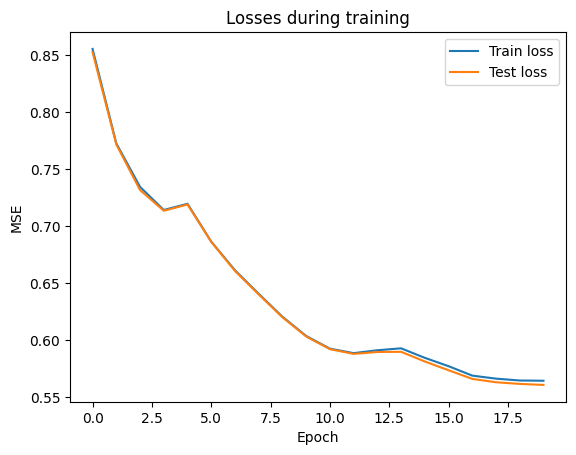

In [18]:
plt.plot(range(n_epochs), losses, test_losses)
plt.title("Losses during training")
plt.legend(['Train loss', 'Test loss'])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

### Evaluation

For Fuzzy networks two weight matrices are of interest: The condition matrix and the consequence matrix. Both have prior knowledge infused into them. By visualizing those weights, we can gain knowledge about our problem and maybe change some rules and relations.

Normally, the rule matrix should not change or only alter the one-initialized weights. By turning off pruning and allowing all weights to be trained (`prune_weights=False`, `learn_conditions=True`), we can check if our predefined rules are good or bad.

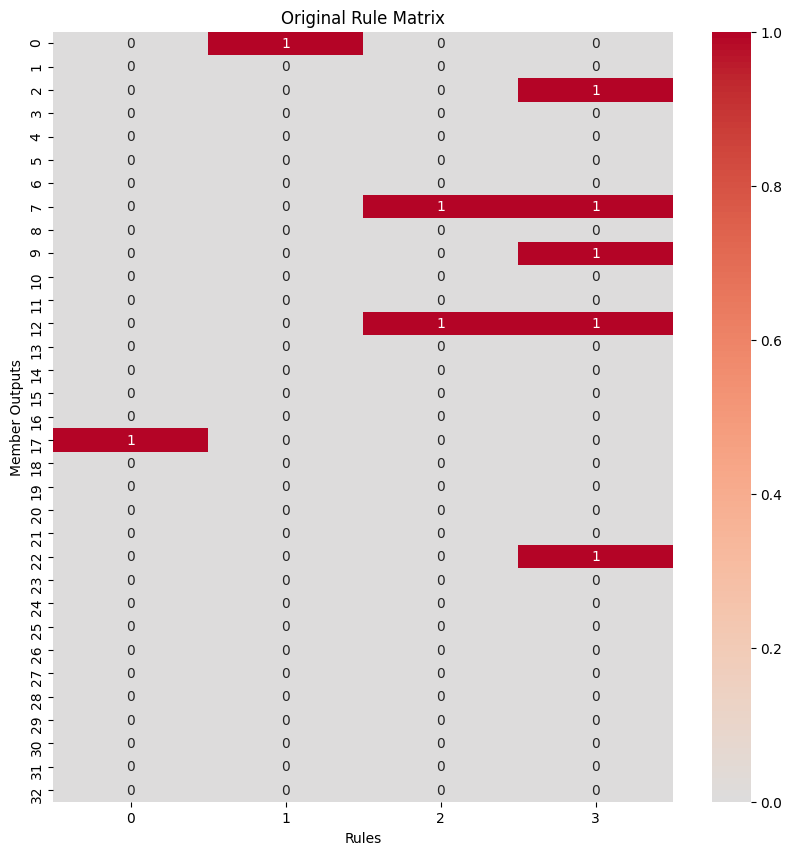

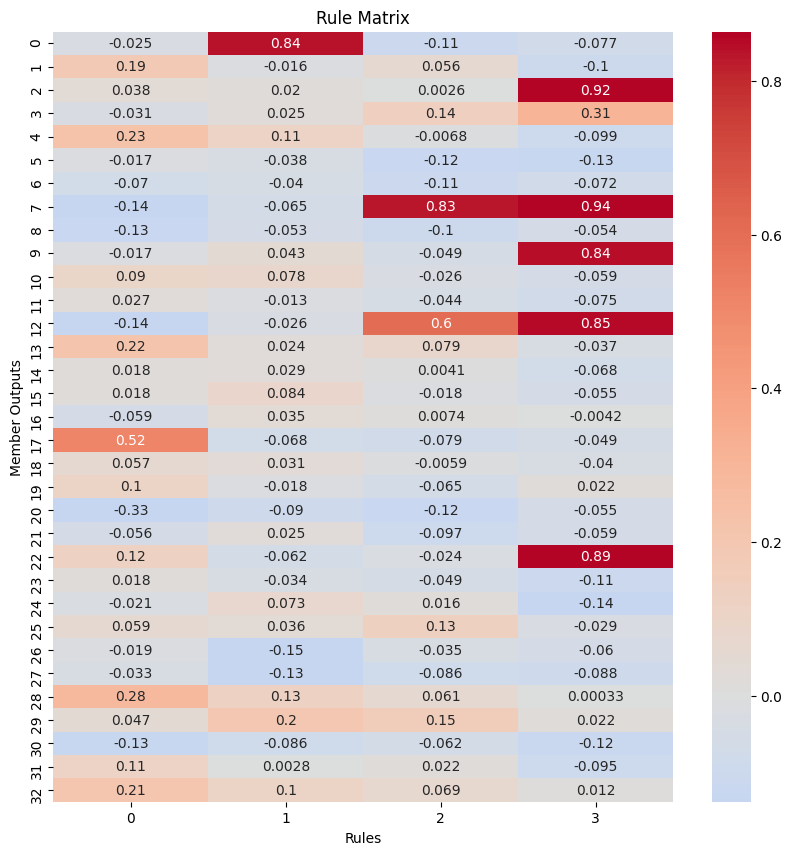

In [23]:
original_rule_matrix = np.reshape(
    rule_manager.rule_matrix, (n_rules, n_features_input * n_membership_fcts)
).T
plot_heatmap(
    original_rule_matrix,
    xlabel="Rules",
    ylabel="Member Outputs",
    title="Original Rule Matrix",
    annot=True,
    fmt=".2g",
    center=0.0,
    figsize=(10, 10),
)

trained_rule_matrix = np.reshape(
    fuzzy[1].conditions.weight.detach().numpy(),
    (n_rules, n_features_input * n_membership_fcts),
).T

plot_heatmap(
    trained_rule_matrix,
    xlabel="Rules",
    ylabel="Member Outputs",
    title="Rule Matrix",
    annot=True,
    fmt=".2g",
    center=0.0,
    figsize=(10, 10),
)

A good rule will keep the already high weights high or even increase them and lower all other, zero initialized weights. This would only strengthen the relation this rule already implied. The second rule is an example. 
If on the other hand a rule is changing very much, hence loosing its original meaning, it probably is worth rechecking that rule, altering it or even discarding it all together. The first rule is an example for that. A similar approach can be taken when pruning the weights but allowing the remaining ones to change (`prune_weights=True`, `learn_conditions=True`). Here weak and strong rules can be discovered too.

The `consequences` matrix allows us to see which rules the network finds useful for classifying each class. Each column sums up to one. The entries of the matrix say how much the network trusts the rule for the classification of the column's class. 

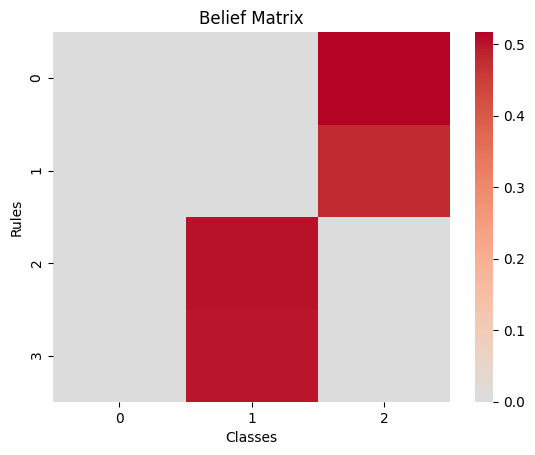

In [24]:
belief_matrix = fuzzy[1].consequences.weight.detach().numpy().T
plot_heatmap(
    belief_matrix, xlabel="Classes", ylabel="Rules", title="Belief Matrix", center=0.0
)

Here again weak rules can be found. In contrast to before, if a rule is weak in this matrix, it might be correct but does not contribute much for classifying the classes.